# UTSA CS 6243 - Machine Learning: Final Project

Fall 2021

Team Members:

**Banna - Hasanul - (bxw174)**

**Tasnim - Umama - (mus854)**

Import Required Libraries

In [34]:
import numpy as np
import cv2

from tensorflow.keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten,Conv2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from google.colab import drive

Mount Drive Directory

In [35]:
drive.mount('/content/drive')
dir_train = "/content/drive/MyDrive/UTSA/Fall_2021/CS-6243_Machine_Learning/Final_Project/dataset/train"
dir_test = "/content/drive/MyDrive/UTSA/Fall_2021/CS-6243_Machine_Learning/Final_Project/dataset/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training Initialization

In [36]:
# Normalization: Scaling data to the range of 0-1 is traditionally referred to as normalization.
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

# Making train data from the set of images.
train_data = train_data_gen.flow_from_directory(
    directory=dir_train,
    target_size= (48,48), #Change later to find the values.
    batch_size=48,
    color_mode='grayscale',
    class_mode='categorical'
)
# Making test data from the set of images.
test_data = train_data_gen.flow_from_directory(
    directory=dir_test,
    target_size= (48,48), #Change later to find the values.
    batch_size=48,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28710 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Normalization of the Dataset

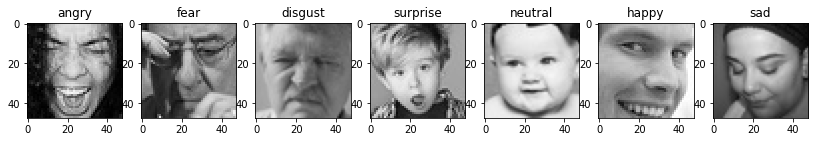

In [37]:
plt.figure(figsize=(14,22))
counter = 1
for expression in os.listdir(dir_train):
    img = load_img((dir_train+"/" + expression +'/'+ os.listdir(dir_train +"/"+ expression)[1]))
    plt.subplot(1,7,counter)
    plt.imshow(img)
    plt.title(expression)
    counter += 1
plt.show()

Defining CNN

In [38]:
model = Sequential([

        # input layer
        Conv2D(filters=32,
               kernel_size=(3,3),
               padding='same',
               activation = 'relu',
               input_shape=(48,48,1)),
        Conv2D(filters=64,
               kernel_size=(3,3),
               padding='same', 
               activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        #hidden layers
        # 1st layers
        Conv2D(filters=128,
               kernel_size=(3,3), 
               padding='same', 
               activation='relu',
               kernel_regularizer=l2(0.001)),
    
        # 2nd layer
        Conv2D(filters=256, 
               kernel_size=(3,3), 
               padding='same', 
               activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
     # 3rd layer
        Conv2D(filters=512, 
               kernel_size=(3,3), 
               padding='same', 
               activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        # Flattenning the layer and passing making NN
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
    
    
        # output layer
        Dense(7, activation='softmax')
    ])
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01,),metrics=['accuracy'])

Printing the summary of the model

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)      

Callbacks

In [41]:
filepath = "emotion-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="min")

earlystop = EarlyStopping(monitor='val_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001)

callbacks = [checkpoint, earlystop, reduce_lr]

Train the Model

In [ ]:
emotion_model_info = model.fit(
        train_data,
        steps_per_epoch=train_data.samples // 48,
        epochs=100,
        validation_data=test_data,
        validation_steps=test_data.samples // 48,
        callbacks=callbacks)
model.save_weights("emotion_model.h5")

Saving the Model

In [25]:
model.save_weights("emotion_model.h5")

In [ ]:
model.save_weights('model.h5')
print(emotion_model_info.history.keys())
plt.plot(range(50),emotion_model_info.history["accuracy"],label="train")
plt.plot(range(50),emotion_model_info.history["val_accuracy"],label="validation")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Valid Accuracy over the epochs",size=15)
plt.savefig('acc_val_acc.png', transparent=True)

In [ ]:
print(emotion_model_info.history.keys())
plt.plot(range(50),emotion_model_info.history["val_loss"],label="validation")
plt.plot(range(50),emotion_model_info.history["loss"],label="train")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Valid Loss over the epochs",size=15)
plt.savefig('val_loss_vs_loss.png', transparent=True)

In [ ]:
train_loss, train_accu = model.evaluate(train_data)
test_loss, test_accu = model.evaluate(test_data)
print("Final training accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
print("Final training loss = {:.2f} , validation loss = {:.2f}".format(train_loss, test_loss))

Emotion detection using OpenCV

In [ ]:
# define a video capture object
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
vid_path = ("/content/drive/MyDrive/UTSA/Fall_2021/CS-6243_Machine_Learning/Final_Project/test.mp4")
vid = cv2.VideoCapture(vid_path)
while(True):

    # Capture the video frame by frame
    ret, frame = vid.read()

    if not ret:
        break

    face_region = cv2.CascadeClassifier("/content/drive/MyDrive/UTSA/Fall_2021/CS-6243_Machine_Learning/Final_Project/haarcascade_frontalface_default.xml")
    #face_region = cv2.CascadeClassifier(
    #    cv2.data.haarcascades+
    #    "haarcascade_frontalface_default.xml"
    #)

    # converting to grayscale, as IT take value in opposite direction BGR, using grayscale
    # make it easy to compute as it only has one channel only.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_region.detectMultiScale(
        gray, scaleFactor=1.3, minNeighbors=5)

    if faces == ():
        print("No faces found")

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (127, 0, 255), 2)
        roi_gray = gray[y:y+h, x:x+w]
        cropped_img = np.expand_dims(np.expand_dims(
            cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        max_index = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[max_index], (x+15, y+20),
                    cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (127, 0, 255), 2, cv2.LINE_4)
    # Display the resulting frameq
    cv2.imshow("frame", frame)
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()